In [137]:
%matplotlib inline

In [138]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 25, 10

In [139]:
full = pd.read_csv('data/cardio_train.csv', sep=';')
full.set_index('id', inplace=True)


## Pre procesado de datos
Dentro de la area del pre-procesado de datos del Trabajo Practico vamos a eliminar todos aquellos valores que no condicen con una situación real de un paciente. **Las variables dentro de nuestro Dataset que contienen estos valores que no reflejan la realidad son: Presión arterial (ambas), y peso.**


In [140]:
#Eliminamos todos aquellos valores que no se encuentren en el rango (40,250)
full =full[full['ap_hi'] <= 250]
full =full[full['ap_hi'] >= 40]

#Eliminamos todos aquellos valores que no se encuentren en el rango (0,200)
full =full[full['ap_lo'] <= 200]
full =full[full['ap_lo'] >= 0]

#Eliminamos todos aquellos valores que se encuentren por debajo de 60 kilogramos
full =full[full['height'] >= 60]

## Feature Ingineering
Dentro de este apartado, vamos a buscar mejorar la capacidad de expresar el problema, a traves de Feature Ingineering. A partir de la técnica denominada **binning/redondeo de números** vamos a convertir la **edad del paciente** de días a años y el **la altura del paciente** de centimetros a metros.

In [141]:
# Transformamos edad de dias a años
full['age'] = full['age']/365

# Transformamos la altura de centimetros a metros
full['height'] = full['height']/100

Otra tecnica que vamos a utilizar es generar una nueva varieble: A partir de el **peso** y la **altura** generaremos una nueva variable que denominaremos Masa corporal. 

In [143]:
# Generamos la variable masa corporal
full['body_mass'] = full['weight']/(full['height'] * full['height'])

# Mostramos el Dataset modificado
full.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,body_mass
id,,,,,,,,,,,,,
0,50.391781,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120
1,55.419178,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679
2,51.663014,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805
3,48.282192,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479
4,47.873973,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177


In [205]:
full.dtypes

age            float64
gender           int64
height         float64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
body_mass      float64
dtype: object

In [144]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(full, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [207]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs) 
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        #print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['has_disease', 'hasnt_disease'], rotation=45)
        plt.yticks([0, 1], ['has_disease', 'hasnt_disease'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

## Métricas
En nuestro caso contamos con el set de datos perfectamente balanceado (50-50 % antes del pre-procesado y 49-51 % luedo de la limpieza), por lo que vamos a utilizar como métrica Accuracy.
Esta métrica es muy buena para la clacificación cuando el dataset está bien balanceado, evitando problemas como por ejemplo que prediga siempre la misma clase.
Esta métrica nos va a indicar el porcentaje de aciertos que tuvimos
También vamos a utilizar la metrica Recall ya que nos interesa encontrar la mayor cantidad posible de casos positivos


## First model: logistic regression

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [151]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'age',
    'sex_m',
    'sex_f',
    'height',
    'weight',
    'ap_hi',
    'ap_lo',
    'cho_lo',
    'cho_me',
    'cho_hi',
    'gluc_lo',
    'gluc_me',
    'gluc_hi',
    'smoke',
    'alco',
    'active',
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # sex to numbers
    inputs['sex_m'] = inputs.gender == 2
    inputs['sex_f'] = inputs.gender == 1
    del inputs['gender']
    
    # cholesterol at to numbers
    inputs['cho_lo'] = inputs.cholesterol == 1
    inputs['cho_me'] = inputs.cholesterol == 2
    inputs['cho_hi'] = inputs.cholesterol == 3
    del inputs['cholesterol']
    
    # gluc at to numbers
    inputs['gluc_lo'] = inputs.gluc == 1
    inputs['gluc_me'] = inputs.gluc == 2
    inputs['gluc_hi'] = inputs.gluc == 3
    del inputs['gluc']
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.cardio.values

In [152]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [153]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

/home/iganciorey/ML/TP1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

train ################################################################################
Accuracy: 0.7282700830689497
Recall: 0.6701639664259224



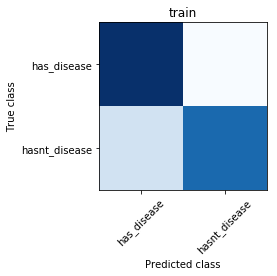

test ################################################################################
Accuracy: 0.7242807323452485
Recall: 0.658037946756876



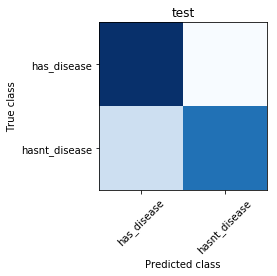

In [208]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [209]:
lr_model.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False))]

In [210]:
clf = lr_model.steps[1][1]
clf.coef_

array([[ 0.34529037,  0.00264482, -0.00264482, -0.03305707,  0.15519643,
         0.90354766,  0.14742931, -0.16260703, -0.00188476,  0.22339381,
         0.02238095,  0.0255221 , -0.05586635, -0.04812505, -0.04407263,
        -0.08855581]])

In [211]:
for col_name, weight in zip(LR_INPUT_COLUMNS, clf.coef_[0]):
    print(col_name, ':', weight)

age : 0.3452903726412635
sex_m : 0.0026448204310715695
sex_f : -0.0026448204310717243
height : -0.03305707290152479
weight : 0.1551964310664396
ap_hi : 0.9035476607504239
ap_lo : 0.1474293097928001
cho_lo : -0.16260702673780217
cho_me : -0.0018847623044000645
cho_hi : 0.22339381320700435
gluc_lo : 0.022380947078019676
gluc_me : 0.02552209614758681
gluc_hi : -0.055866353942494285
smoke : -0.04812504669517902
alco : -0.044072631514500096
active : -0.08855580768753431


### Conclusión
En este modelo, utilizando las métricas mencionadas anteriormente, obtuvimos un 72% en Accuracy y un 65% en Recall en la validación.
Aunque el recall no es muy alto, lo vemos aceptable; ya que encontramos más de la mitad de los casos

## Second model: K nearest neighbors

In [212]:
from sklearn.neighbors import KNeighborsClassifier

In [213]:
K = 100

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [214]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform'))])

train ################################################################################
Accuracy: 0.7305223898670412
Recall: 0.6726527425336717



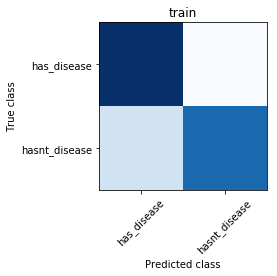

test ################################################################################
Accuracy: 0.7240627724498693
Recall: 0.6593616708339461



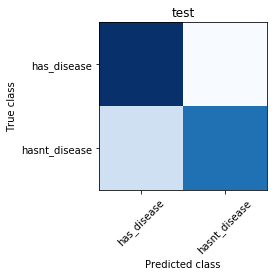

In [215]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

### Conclusión
Al igual que con el modelo anterior, obtuvimos en validación un 72% en Accuracy y un 65% en Recall
Podemos obervar también que los resultados de la validación son casi identicos a los del entrenamiento, lo que nos da indicios de que el modelo se comporta de la misma forma con datos nuevos

## Third model: Decision Trees


In [219]:
from sklearn.tree import DecisionTreeClassifier

In [220]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'age',
    'gender',
    'height',
    'weight',
    'ap_hi',
    'ap_lo',
    'cholesterol',
    'gluc',
    'smoke',
    'alco',
    'active',
    'body_mass'
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.cardio.values

In [239]:
tree_model = DecisionTreeClassifier(max_depth=10)
# max_depth=5?

In [240]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

train ################################################################################
Accuracy: 0.7562180620474195
Recall: 0.7220866679679875



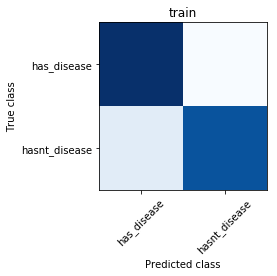

test ################################################################################
Accuracy: 0.7207207207207207
Recall: 0.6853949110163259



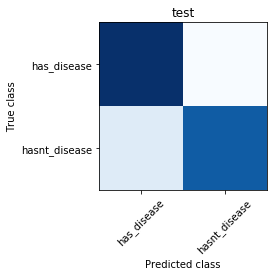

In [241]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

In [224]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=TREE_INPUT_COLUMNS,  
        class_names=['has_disease', 'hasnt_disease'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

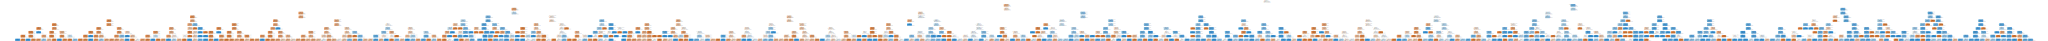

In [189]:
graph_tree(tree_model)

### Conclusión
En este modelo podemos observar que obtuvimos resultados levemente mejores que con los dos anteriores.
Podemos agrear que son más fáciles de sobrenrenar que la regresión lineal y el K-NN, ya que tuvimos que configurarlo con una profundidad máxima de 10 niveles porque arrojaba resultados por encima del 99% en el train y en el validation solo llegabamos al 60 %

## Fourth model: Random Forests

In [242]:
from sklearn.ensemble import RandomForestClassifier

In [258]:
forest_model = RandomForestClassifier(max_depth=10)
# n_estimators? max_depth=3?, max_features=2?

In [259]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

/home/iganciorey/ML/TP1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train ################################################################################
Accuracy: 0.7574531980334698
Recall: 0.7088131953933242



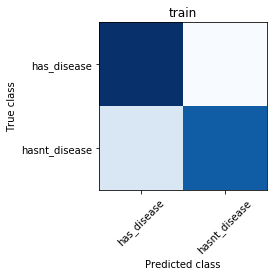

test ################################################################################
Accuracy: 0.7278407439697763
Recall: 0.673922635681718



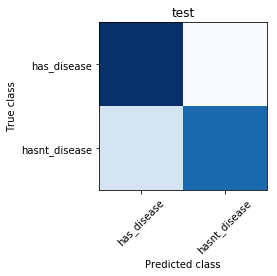

In [260]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

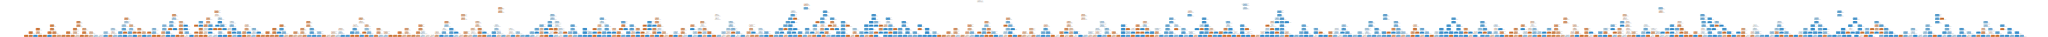

In [261]:
graph_tree(forest_model.estimators_[0])

### Conclusión
Al igual que en el modelo anterior, obtuvimos resultados levemente mejores que con la regresión lineal y el K-NN.
Con resultados del 72 % con Accuracy y 67 % con Recall concluimos que este modelo es aceptable


## Fifth model: Gradient Boosted Trees

In [195]:
from sklearn.ensemble import GradientBoostingClassifier

In [196]:
boost_model = GradientBoostingClassifier()

In [197]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

train ################################################################################
Accuracy: 0.7385628829527016
Precision: 0.7524865906368796
Recall: 0.7051532305289869



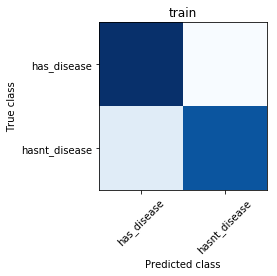

test ################################################################################
Accuracy: 0.7321999418773613
Precision: 0.7455434611137404
Recall: 0.6951022209148404



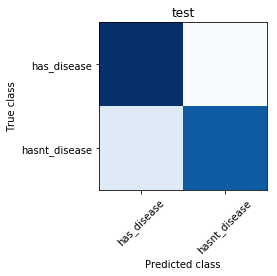

In [198]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

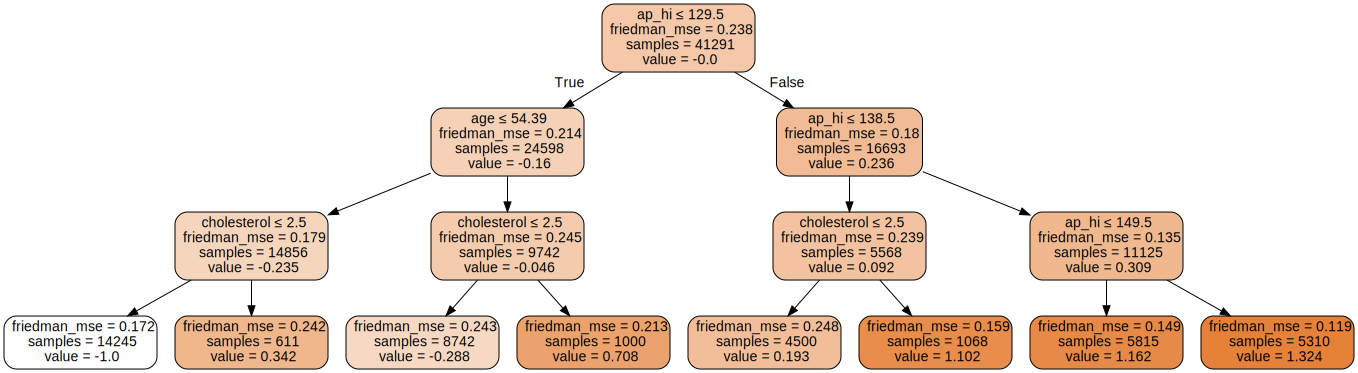

In [199]:
graph_tree(boost_model.estimators_[1][0])

## Sixth model: Neural Networks

In [200]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

In [203]:
nn_model = Sequential([   
    Dense(100, input_shape=(len(LR_INPUT_COLUMNS), )),
    Activation('tanh'),
    
    Dropout(0.1), 

    Dense(100),
    Activation('tanh'),
    
    Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [204]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Train on 41291 samples, validate on 13764 samples
Epoch 1/500
41291/41291 [==============================] - 2s 42us/step - loss: 0.6808 - acc: 0.5729 - val_loss: 0.6630 - val_acc: 0.5974
Epoch 2/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.6624 - acc: 0.6047 - val_loss: 0.6560 - val_acc: 0.6127
Epoch 3/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.6472 - acc: 0.6286 - val_loss: 0.6265 - val_acc: 0.6524
Epoch 4/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.6332 - acc: 0.6498 - val_loss: 0.6204 - val_acc: 0.6617
Epoch 5/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.6272 - acc: 0.6563 - val_loss: 0.6139 - val_acc: 0.6716
Epoch 6/500
41291/41291 [==============================] - 1s 26us/step - loss: 0.6186 - acc: 0.6614 - val_loss: 0.6064 - val_acc: 0.6702
Epoch 7/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.6102 - acc: 0.6746 - val_loss: 0.6010 - 

41291/41291 [==============================] - 1s 26us/step - loss: 0.5554 - acc: 0.7234 - val_loss: 0.5510 - val_acc: 0.7281
Epoch 60/500
41291/41291 [==============================] - 1s 26us/step - loss: 0.5528 - acc: 0.7246 - val_loss: 0.5509 - val_acc: 0.7251
Epoch 61/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5527 - acc: 0.7258 - val_loss: 0.5530 - val_acc: 0.7251
Epoch 62/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5549 - acc: 0.7238 - val_loss: 0.5601 - val_acc: 0.7249
Epoch 63/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5526 - acc: 0.7257 - val_loss: 0.5484 - val_acc: 0.7308
Epoch 64/500
41291/41291 [==============================] - 1s 27us/step - loss: 0.5535 - acc: 0.7249 - val_loss: 0.5561 - val_acc: 0.7260
Epoch 65/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5565 - acc: 0.7231 - val_loss: 0.5547 - val_acc: 0.7245
Epoch 66/500
41291/41291 [==============

Epoch 118/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5514 - acc: 0.7268 - val_loss: 0.5500 - val_acc: 0.7262
Epoch 119/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5526 - acc: 0.7269 - val_loss: 0.5555 - val_acc: 0.7262
Epoch 120/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5518 - acc: 0.7274 - val_loss: 0.5486 - val_acc: 0.7301
Epoch 121/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5520 - acc: 0.7270 - val_loss: 0.5482 - val_acc: 0.7294
Epoch 122/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5514 - acc: 0.7257 - val_loss: 0.5501 - val_acc: 0.7241
Epoch 123/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5494 - acc: 0.7275 - val_loss: 0.5709 - val_acc: 0.7172
Epoch 124/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5522 - acc: 0.7273 - val_loss: 0.5490 - val_acc: 0.7305
Epoch 125/500
41291/

41291/41291 [==============================] - 1s 27us/step - loss: 0.5505 - acc: 0.7281 - val_loss: 0.5739 - val_acc: 0.6951
Epoch 177/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5507 - acc: 0.7275 - val_loss: 0.5504 - val_acc: 0.7299
Epoch 178/500
41291/41291 [==============================] - 1s 22us/step - loss: 0.5502 - acc: 0.7274 - val_loss: 0.5558 - val_acc: 0.7214
Epoch 179/500
41291/41291 [==============================] - 1s 22us/step - loss: 0.5490 - acc: 0.7302 - val_loss: 0.5592 - val_acc: 0.7137
Epoch 180/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5501 - acc: 0.7276 - val_loss: 0.5477 - val_acc: 0.7307
Epoch 181/500
41291/41291 [==============================] - 1s 22us/step - loss: 0.5514 - acc: 0.7266 - val_loss: 0.5483 - val_acc: 0.7315
Epoch 182/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5492 - acc: 0.7303 - val_loss: 0.5501 - val_acc: 0.7291
Epoch 183/500
41291/41291 [=======

41291/41291 [==============================] - 1s 28us/step - loss: 0.5492 - acc: 0.7294 - val_loss: 0.5538 - val_acc: 0.7255
Epoch 235/500
41291/41291 [==============================] - 1s 26us/step - loss: 0.5498 - acc: 0.7292 - val_loss: 0.5665 - val_acc: 0.7148
Epoch 236/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5497 - acc: 0.7291 - val_loss: 0.5485 - val_acc: 0.7310
Epoch 237/500
41291/41291 [==============================] - 1s 26us/step - loss: 0.5491 - acc: 0.7296 - val_loss: 0.5462 - val_acc: 0.7316
Epoch 238/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.5489 - acc: 0.7312 - val_loss: 0.5501 - val_acc: 0.7302
Epoch 239/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5490 - acc: 0.7297 - val_loss: 0.5499 - val_acc: 0.7276
Epoch 240/500
41291/41291 [==============================] - 1s 26us/step - loss: 0.5472 - acc: 0.7292 - val_loss: 0.5484 - val_acc: 0.7307
Epoch 241/500
41291/41291 [=======

41291/41291 [==============================] - 1s 24us/step - loss: 0.5474 - acc: 0.7315 - val_loss: 0.5486 - val_acc: 0.7271
Epoch 293/500
41291/41291 [==============================] - 1s 26us/step - loss: 0.5476 - acc: 0.7304 - val_loss: 0.5511 - val_acc: 0.7274
Epoch 294/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.5476 - acc: 0.7295 - val_loss: 0.5489 - val_acc: 0.7291
Epoch 295/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.5505 - acc: 0.7294 - val_loss: 0.5468 - val_acc: 0.7305
Epoch 296/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.5482 - acc: 0.7297 - val_loss: 0.5503 - val_acc: 0.7270
Epoch 297/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5474 - acc: 0.7283 - val_loss: 0.5494 - val_acc: 0.7269
Epoch 298/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5474 - acc: 0.7308 - val_loss: 0.5483 - val_acc: 0.7295
Epoch 299/500
41291/41291 [=======

41291/41291 [==============================] - 1s 23us/step - loss: 0.5472 - acc: 0.7304 - val_loss: 0.5506 - val_acc: 0.7281
Epoch 351/500
41291/41291 [==============================] - 1s 22us/step - loss: 0.5477 - acc: 0.7311 - val_loss: 0.5468 - val_acc: 0.7290
Epoch 352/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5470 - acc: 0.7313 - val_loss: 0.5528 - val_acc: 0.7268
Epoch 353/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5475 - acc: 0.7296 - val_loss: 0.5586 - val_acc: 0.7242
Epoch 354/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5476 - acc: 0.7312 - val_loss: 0.5464 - val_acc: 0.7306
Epoch 355/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5480 - acc: 0.7294 - val_loss: 0.5476 - val_acc: 0.7299
Epoch 356/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5503 - acc: 0.7273 - val_loss: 0.5505 - val_acc: 0.7283
Epoch 357/500
41291/41291 [=======

41291/41291 [==============================] - 1s 23us/step - loss: 0.5461 - acc: 0.7322 - val_loss: 0.5476 - val_acc: 0.7289
Epoch 409/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5466 - acc: 0.7330 - val_loss: 0.5494 - val_acc: 0.7268
Epoch 410/500
41291/41291 [==============================] - 1s 22us/step - loss: 0.5463 - acc: 0.7313 - val_loss: 0.5487 - val_acc: 0.7303
Epoch 411/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5480 - acc: 0.7293 - val_loss: 0.5498 - val_acc: 0.7260
Epoch 412/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5484 - acc: 0.7306 - val_loss: 0.5491 - val_acc: 0.7276
Epoch 413/500
41291/41291 [==============================] - 1s 23us/step - loss: 0.5465 - acc: 0.7302 - val_loss: 0.5492 - val_acc: 0.7278
Epoch 414/500
41291/41291 [==============================] - 1s 22us/step - loss: 0.5471 - acc: 0.7298 - val_loss: 0.5493 - val_acc: 0.7293
Epoch 415/500
41291/41291 [=======

41291/41291 [==============================] - 1s 25us/step - loss: 0.5477 - acc: 0.7296 - val_loss: 0.5474 - val_acc: 0.7300
Epoch 467/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5453 - acc: 0.7323 - val_loss: 0.5509 - val_acc: 0.7221
Epoch 468/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5470 - acc: 0.7294 - val_loss: 0.5505 - val_acc: 0.7296
Epoch 469/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5478 - acc: 0.7303 - val_loss: 0.5465 - val_acc: 0.7282
Epoch 470/500
41291/41291 [==============================] - 1s 25us/step - loss: 0.5480 - acc: 0.7304 - val_loss: 0.5484 - val_acc: 0.7267
Epoch 471/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5476 - acc: 0.7295 - val_loss: 0.5489 - val_acc: 0.7255
Epoch 472/500
41291/41291 [==============================] - 1s 24us/step - loss: 0.5474 - acc: 0.7298 - val_loss: 0.5493 - val_acc: 0.7290
Epoch 473/500
41291/41291 [=======

train ################################################################################
Accuracy: 0.7305223898670412
Precision: 0.7572378179420974
Recall: 0.6726527425336717



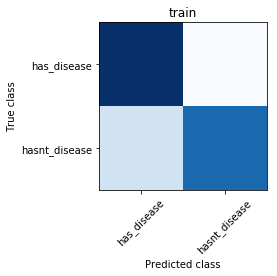

test ################################################################################
Accuracy: 0.7240627724498693
Precision: 0.7515507124895222
Recall: 0.6593616708339461



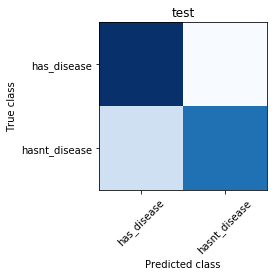

In [206]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

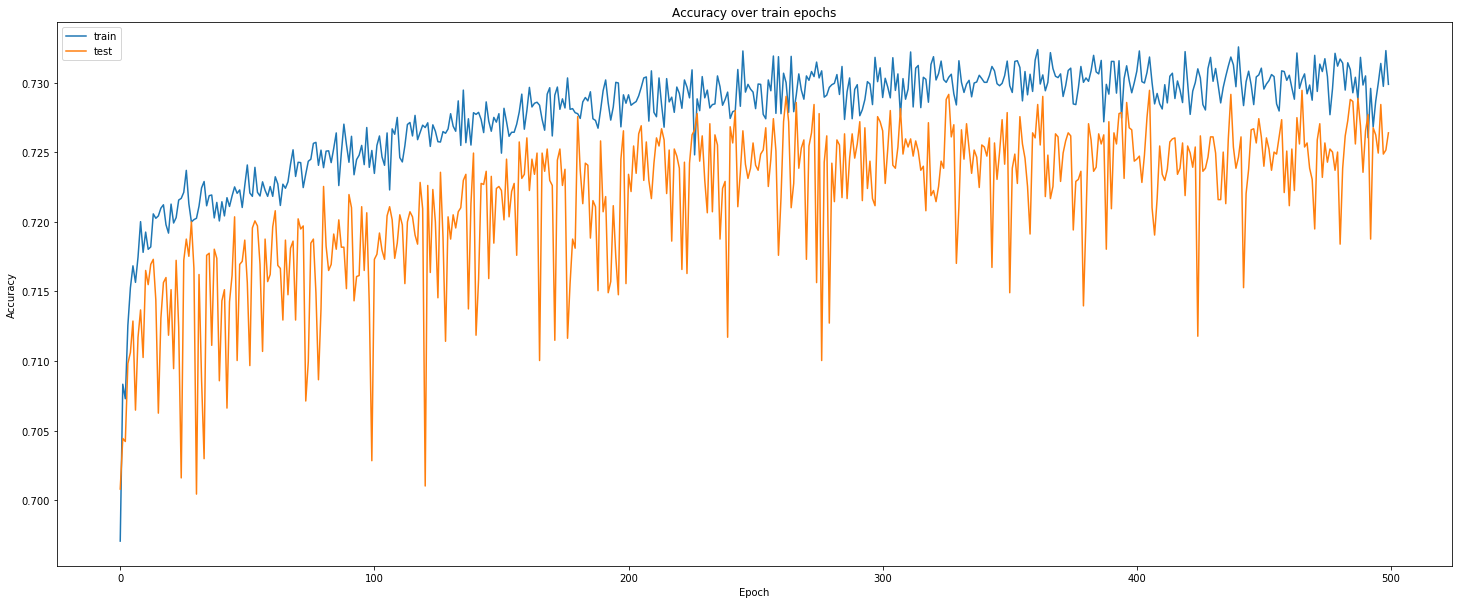

In [70]:
# plot accuracy over training epochs
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()